<a href="https://colab.research.google.com/github/jderazoa/ML-con-PYTHON/blob/master/time_series_interpreting_acf_and_pacf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Autocorrelation analysis is an important step in the Exploratory Data Analysis (EDA) of time series. **The autocorrelation analysis helps in detecting hidden patterns and seasonality and in checking for randomness.**
It is especially important when you intend to use an ARIMA model for forecasting because the autocorrelation analysis helps to identify the AR and MA parameters for the ARIMA model.

**Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)**

- Autocorrelation Function (ACF): Correlation between time series with a lagged version of itself. The autocorrelation function starts a lag 0, which is the correlation of the time series with itself and therefore results in a correlation of 1.
- Partial Autocorrelation Function (PACF): Additional correlation explained by each successive lagged term.

If you need some introduction to or a refresher on the ACF and PACF, I recommend the following video:
<iframe width="700" height="400" src="https://www.youtube.com/embed/DeORzP0go5I" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [ ]:
import numpy as np # linear algebra
from numpy.random import seed 

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from datetime import datetime, date 

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

# Fix seed for reproducible results
SEED = 42
np.random.seed(SEED)

# Data Overview

The following is a fictional time series that we will use to explain some basic concepts similarly as in my other time series tutorial notebook [Time Series Forecasting: Building Intuition](https://www.kaggle.com/iamleonie/time-series-forecasting-building-intuition). 

There are five features:
- `feature_1` is a constant value
- `feature_2` is a linear function
- `feature_3` and `feature_4` are periodical (T=28) with `feature_3` following a sine wave and `feature_4` being a modulo function
- `feature_5` are random values

The time series consists of 100 timesteps.


,timestamp,feature_1,feature_2,feature_3,feature_4,feature_5
0,2021-01-01,5,25.0,22.479328,70.0,88
1,2021-01-02,5,25.5,24.694438,71.0,100
2,2021-01-03,5,26.0,26.395715,72.0,24
3,2021-01-04,5,26.5,27.508409,73.0,3
4,2021-01-05,5,27.0,27.983630,74.0,22


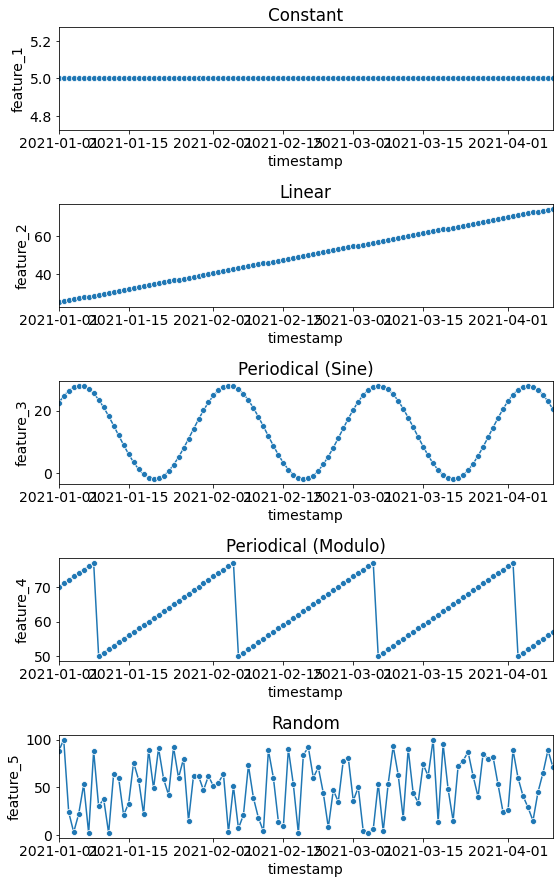

In [ ]:
### Build fictional time series for experimenting ###
n_features = 5
time        = np.arange(0, 1100, 10)

ts_df = pd.DataFrame({'feature_1' : 5, # constant
                      'feature_2' : (0.05*time)+20, # linear
                      'feature_3' : 15*np.sin(0.021*time+30)+13, # periodical
                      'feature_4' : (( time + 100 ) % 280)*0.1 + 50, # periodical
                      'feature_5' : np.random.randint(1,101,len(time)) # random
                     })


# Drop first 90 rows due to shifted variables
ts_df = ts_df[10:110]

# Create timestamps and set as index
ts_df['timestamp'] = pd.date_range('2021-01-01', periods=100, freq='D')
ts_df.set_index('timestamp', inplace=True)
ts_df.reset_index(drop=False, inplace=True)

display(ts_df.head())

### Visualize time series ###
height = n_features * 2.5
width = 8

fig, ax = plt.subplots(nrows=n_features, ncols=1, figsize=(width, height))

for i in range(n_features):
    sns.lineplot(x=ts_df.timestamp, y=ts_df[f'feature_{i+1}'], ax=ax[i], marker='o')
    ax[i].set_xlim([date(2021, 1, 1), date(2021, 4, 10)])

ax[0].set_title('Constant')
ax[1].set_title('Linear')
ax[2].set_title('Periodical (Sine)')
ax[3].set_title('Periodical (Modulo)')
ax[4].set_title('Random')


plt.tight_layout()
plt.show()


# Fundamentals

## Auto-Regressive and Moving Average Models

### Auto-Regressive (AR) Model

<font color='orange'>Auto-Regressive (AR) filter (long term)</font>: 
$\color{orange}{y_t = c + \alpha_1 y_{t-1} + \dots \alpha_{\color{orange}p}y_{t-\color{orange}p} + \epsilon_t = c + \sum_{i=1}^p{\alpha_i}y_{t-i} + \epsilon_t}$

### Moving Average (MA) Model

<font color='blue'>Moving Average (MA) filter (short term)</font>:
$\color{blue}{y_t = c + \epsilon_t + \beta_1 \epsilon_{t-1} + \dots + \beta_{q} \epsilon_{t-q} = c + \epsilon_t + \sum_{i=1}^q{\beta_i}\epsilon_{t-i}} $



## Correlation

![Scatter-Plots-and-Correlation-Examples.png](attachment:666ee9a9-d649-4d25-bb5c-50c414663310.png)

Photo by <a href="https://cqeacademy.com/cqe-body-of-knowledge/continuous-improvement/quality-control-tools/the-scatter-plot-linear-regression/">CQE Academy</a>
  

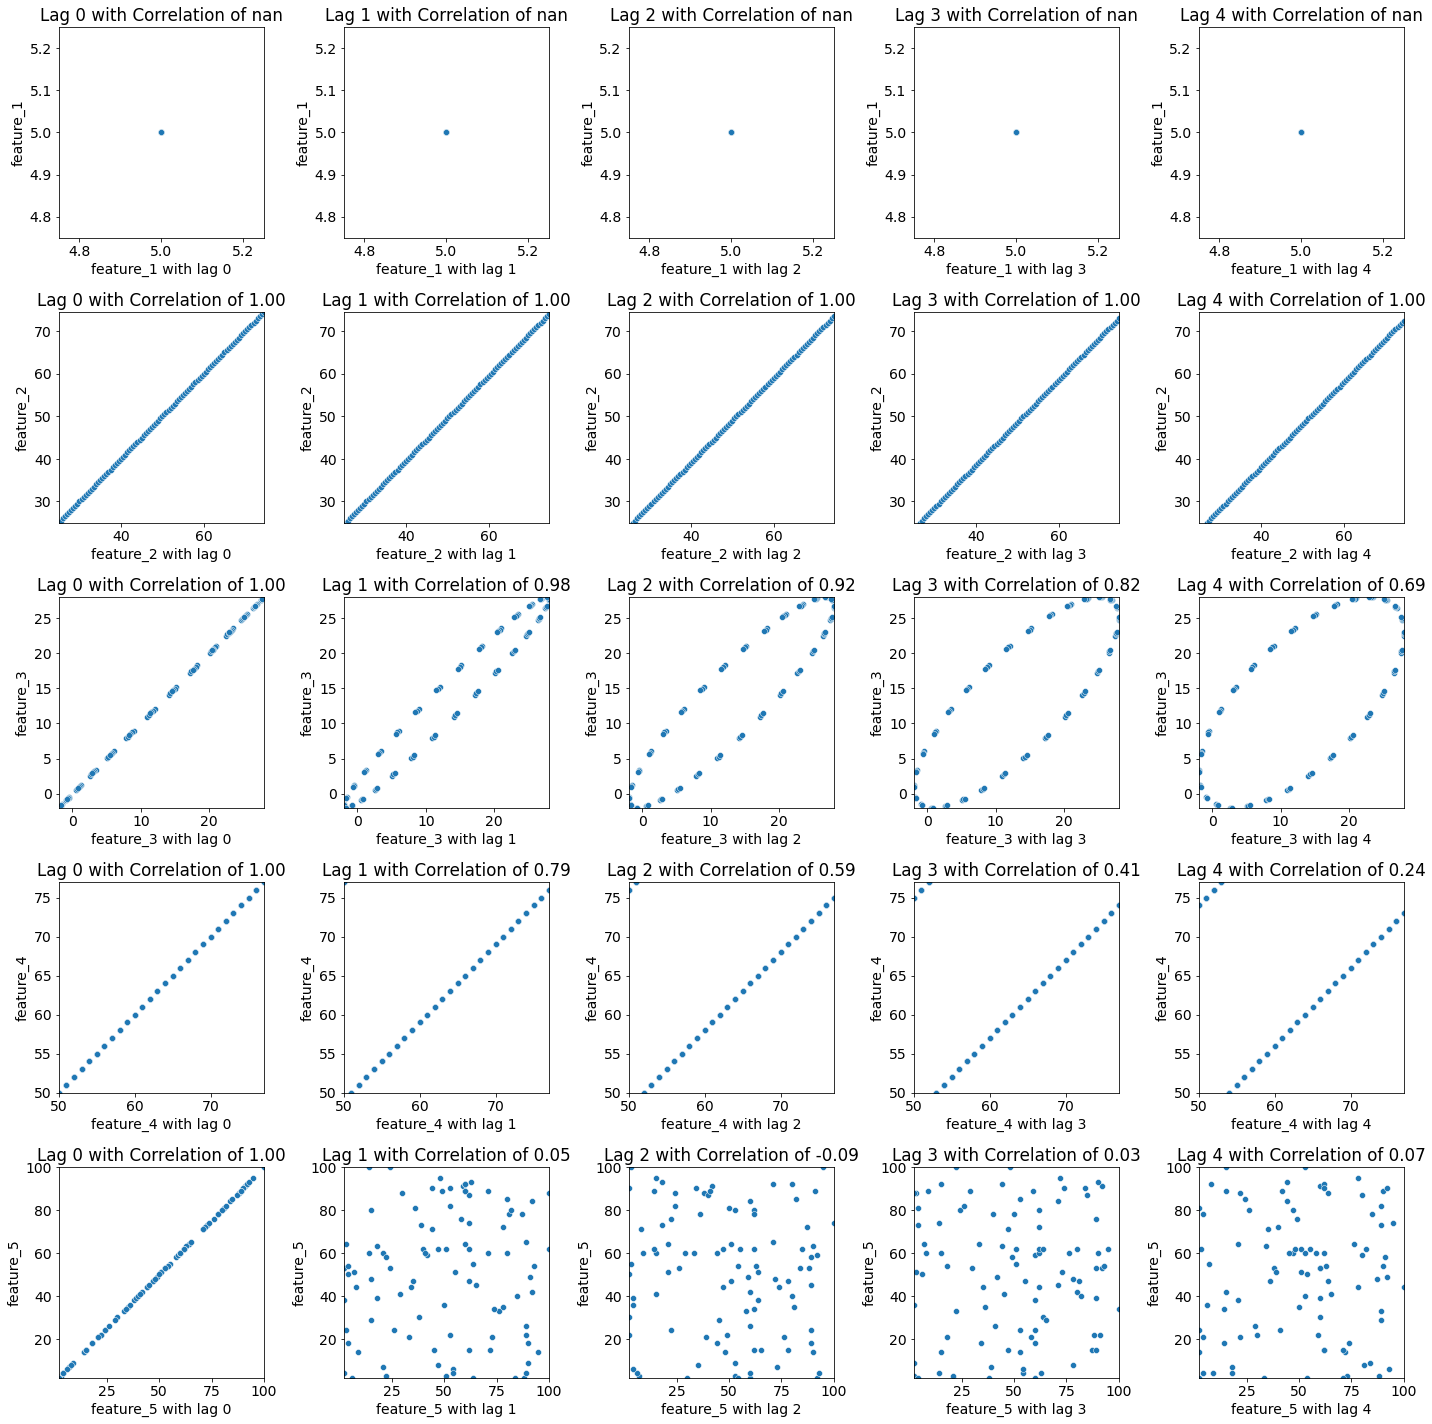

In [ ]:
n_cols = 5
f, ax = plt.subplots(nrows=n_features, ncols=n_cols, figsize=(n_cols*4, n_features*4))

for j in range(n_features):
    for i in range(n_cols):
        sns.scatterplot(x=ts_df[f'feature_{j+1}'], y=ts_df[f'feature_{j+1}'].shift(i), ax=ax[j, i])
        ax[j, i].set_ylim([ts_df[f'feature_{j+1}'].min(), ts_df[f'feature_{j+1}'].max()])
        ax[j, i].set_xlim([ts_df[f'feature_{j+1}'].min(), ts_df[f'feature_{j+1}'].max()])
        ax[j, i].set_title(f"Lag {i} with Correlation of {ts_df[f'feature_{j+1}'].corr(ts_df[f'feature_{j+1}'].shift(i)):.2f}")
        ax[j, i].set_xlabel(f'feature_{j+1}')
        ax[j, i].set_xlabel(f'feature_{j+1} with lag {i}')

plt.tight_layout()
plt.show()

## Stationarity

ACF and PACF assume stationarity of the underlying time series.
Staionarity can be checked by performing an **Augmented Dickey-Fuller (ADF) test**:

> - p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
> - p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
>
> [...] We can see that our [ADF] statistic value [...] is less than the value [...] at 1%.
This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).
Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure. - [Machine Learning Mastery: How to Check if Time Series Data is Stationary with Python](https://machinelearningmastery.com/time-series-data-stationary-python/)

If the time series is stationary, continue to the next steps.
If the time series is not stationary, try differencing the time series and check its stationarity again.


In [ ]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [ ]:
for i in range(1, n_features+1):
    print(f'Feature {i}:')
    check_stationarity(ts_df[f'feature_{i}'])
    print('\n')

Feature 1:
ADF Statistic: nan
p-value: nan
Critical Values:
	1%: -3.498
	5%: -2.891
	10%: -2.583
Non-stationary


Feature 2:
ADF Statistic: 5.149004
p-value: 1.000000
Critical Values:
	1%: -3.503
	5%: -2.893
	10%: -2.584
Non-stationary


Feature 3:
ADF Statistic: -66222687691669.164062
p-value: 0.000000
Critical Values:
	1%: -3.499
	5%: -2.892
	10%: -2.583
Stationary


Feature 4:
ADF Statistic: -3.384686
p-value: 0.011492
Critical Values:
	1%: -3.498
	5%: -2.891
	10%: -2.583
Stationary


Feature 5:
ADF Statistic: -9.470432
p-value: 0.000000
Critical Values:
	1%: -3.498
	5%: -2.891
	10%: -2.583
Stationary




In this example, `feature_1` and `feature_2` are non-stationary. The other time series are stationary.

# Autocorrelation Function (ACF)

> The autocorrelation plot can provide answers to the following questions:
> - Are the data random?
> - Is an observation related to an adjacent observation?
> - Is an observation related to an observation twice-removed? (etc.)
> - Is the observed time series white noise?
> - Is the observed time series sinusoidal?
> - Is the observed time series autoregressive? 

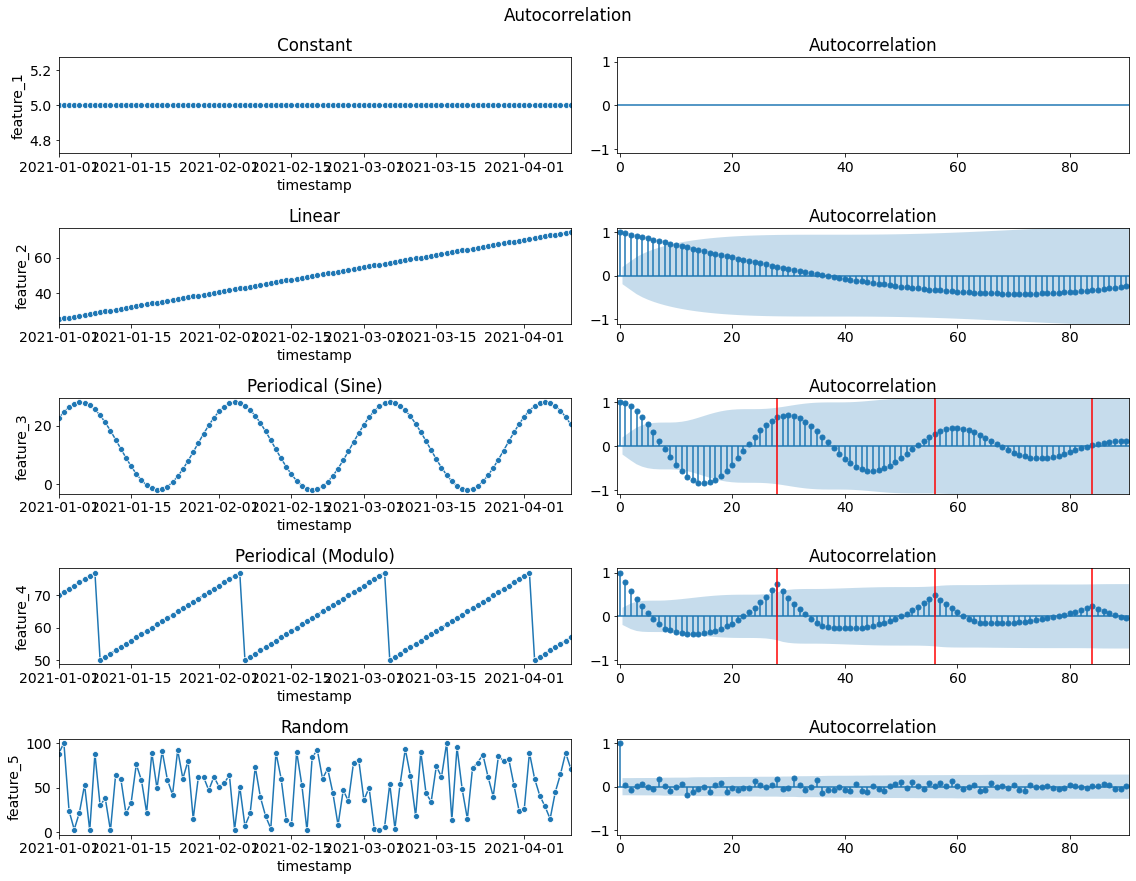

In [ ]:
lag_acf = 90

f, ax = plt.subplots(nrows=n_features, ncols=2, figsize=(width*2, height))

for i in range(n_features):
    sns.lineplot(x=ts_df.timestamp, y=ts_df[f'feature_{i+1}'], ax=ax[i,0], marker='o')
    plot_acf(ts_df[f'feature_{i+1}'],lags=lag_acf, ax=ax[i, 1])
    ax[i, 0].set_xlim([date(2021, 1, 1), date(2021, 4, 10)])
    ax[i, 1].set_xlim([-0.5, lag_acf+0.5])
    ax[i, 1].set_ylim([-1.1, 1.1])

ax[2, 1].axvline(x=28, color='r', linestyle='-')
ax[2, 1].axvline(x=28*2, color='r', linestyle='-')
ax[2, 1].axvline(x=28*3, color='r', linestyle='-')

ax[3, 1].axvline(x=28, color='r', linestyle='-')
ax[3, 1].axvline(x=28*2, color='r', linestyle='-')
ax[3, 1].axvline(x=28*3, color='r', linestyle='-')

ax[0, 0].set_title('Constant')
ax[1, 0].set_title('Linear')
ax[2, 0].set_title('Periodical (Sine)')
ax[3, 0].set_title('Periodical (Modulo)')
ax[4, 0].set_title('Random')

plt.suptitle('Autocorrelation')
plt.tight_layout()
plt.show()


The ACF starts with a lag of 0, which is the correlation of the time series with itself and therefore results in a correlation of 1.
95% confidence interval

## Constant
tbd
- ACF was applied to non-stationary time series

## Linear
- ACF was applied to non-stationary time series
- one or more of the autocorrelations are significantly non-zero: non-random
- high degree of autocorrelation between adjacent and near-adjacent observations
- The data come from an underlying autoregressive model with strong positive autocorrelation. 
- The plot starts with a high autocorrelation at lag 1 (only slightly less than 1) that slowly declines. It continues decreasing until it becomes negative and starts showing an incresing negative autocorrelation. The decreasing autocorrelation is generally linear with little noise. Such a pattern is the autocorrelation plot signature of "strong autocorrelation", which in turn provides high predictability if modeled properly. 

## Periodical

### Sine
- one or more of the autocorrelations are significantly non-zero: non-random
- high degree of autocorrelation between adjacent and near-adjacent observations
- The data come from an underlying sinusoidal model. 
- The plot exhibits an alternating sequence of positive and negative spikes. These spikes are not decaying to zero. Such a pattern is the autocorrelation plot signature of a sinusoidal model. 


### Modulo
- We can observe a peak for multiples of T=28.
- one or more of the autocorrelations are significantly non-zero: non-random
- high degree of autocorrelation between adjacent and near-adjacent observations


## Random
- only for lag 0 the autocorrelations is significantly non-zero: random
- Aside from lag 0, the correlation of the time series with its lagged versions is not notable (within blue range).

# Partial Autocorrelation Function (PACF)

> The partial autocorrelation at lag k is the autocorrelation between $X_t$ and $X_{t−k}$ that is not accounted for by lags 1 through $k−1$. 

> The partial autocorrelation plot can help provide answers to the following questions:
> - Is an AR model appropriate for the data?
> - If an AR model is appropriate, what order should we use?

> This is the critical difference between Autocorrelation and Partial Autocorrelation — the inclusion or exclusion of indirect correlations in the calculation.

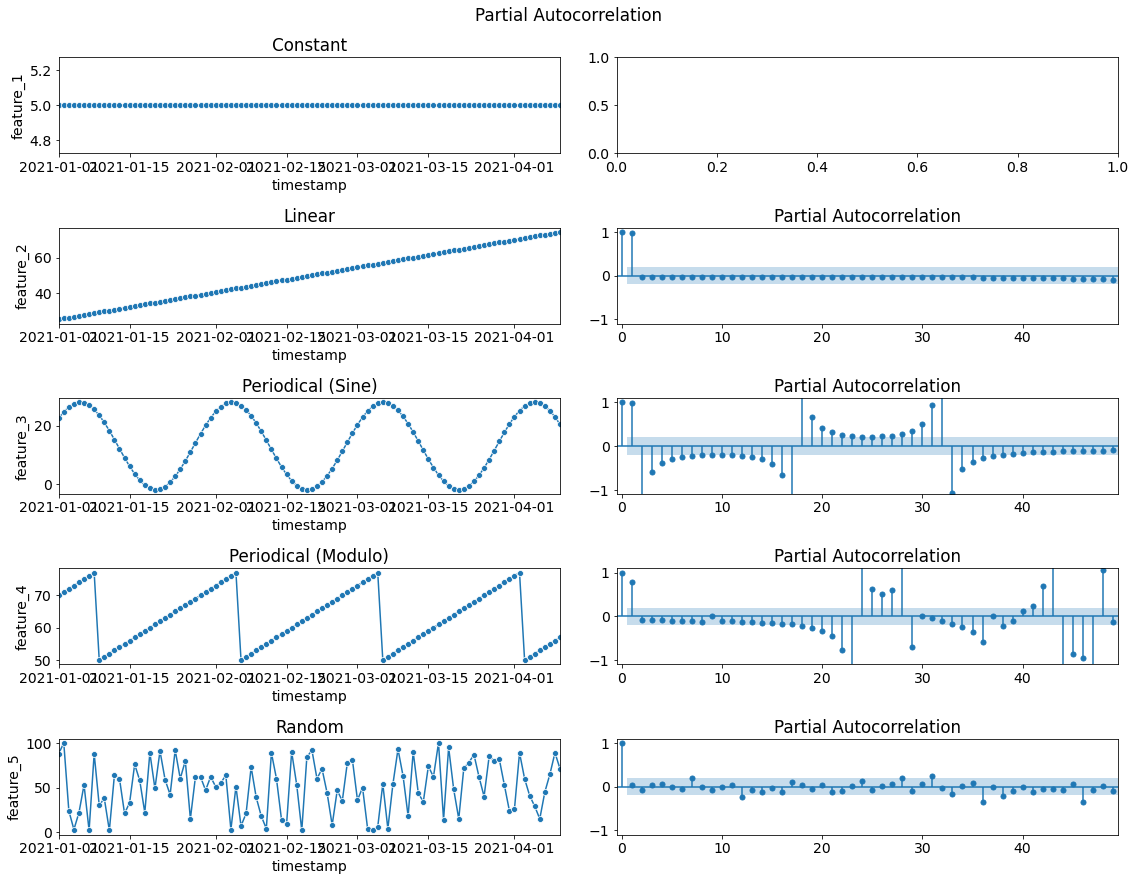

In [ ]:
lag_pacf = 49
f, ax = plt.subplots(nrows=n_features, ncols=2, figsize=(width*2, height))

sns.lineplot(x=ts_df.timestamp, y=ts_df['feature_1'], ax=ax[0,0], marker='o')
ax[0, 0].set_xlim([date(2021, 1, 1), date(2021, 4, 10)])

for i in range(1, n_features):
    sns.lineplot(x=ts_df.timestamp, y=ts_df[f'feature_{i+1}'], ax=ax[i,0], marker='o')
    plot_pacf(ts_df[f'feature_{i+1}'],lags=lag_pacf, ax=ax[i, 1])
    ax[i, 0].set_xlim([date(2021, 1, 1), date(2021, 4, 10)])
    ax[i, 1].set_xlim([-0.5, lag_pacf+0.5])
    ax[i, 1].set_ylim([-1.1, 1.1])

ax[0, 0].set_title('Constant')
ax[1, 0].set_title('Linear')
ax[2, 0].set_title('Periodical (Sine)')
ax[3, 0].set_title('Periodical (Modulo)')
ax[4, 0].set_title('Random')

plt.suptitle('Partial Autocorrelation')
plt.tight_layout()
plt.show()

The PACF starts with a lag of 0, which is the correlation of the time series with itself and therefore results in a correlation of 1.

## Constant
Trying to plot the PACF for `feature_1` will output an error with `LinAlgError: Singular matrix`.
- PACF was applied to non-stationary time series

## Linear
tbd
- PACF was applied to non-stationary time series


## Periodical
tbd

### Sine
tbd

### Modulo
tbd

## Random
tbd


# Case Study
Upcoming: Interpreting ACF and PACF in the [G-Research Crypto Forecasting Competition](https://www.kaggle.com/c/g-research-crypto-forecasting).

In [ ]:
data_folder = "../input/g-research-crypto-forecasting/"

train = pd.read_csv(data_folder + 'train.csv', low_memory=False)

train = train[train.Asset_ID == 1].reset_index()

train['timestamp'] = train['timestamp'].astype('datetime64[s]')
train_mini = train[['timestamp','Close']].resample('D', on='timestamp').last()['Close']
train_mini = train_mini.to_frame().reset_index(drop=False)

train_mini.head(10)

,timestamp,Close
0,2018-01-01,13432.9180
1,2018-01-02,14746.1120
2,2018-01-03,15101.9940
3,2018-01-04,15154.7600
4,2018-01-05,16949.8800
5,2018-01-06,17117.4425
6,2018-01-07,16158.1340
7,2018-01-08,14965.1740
8,2018-01-09,14445.2200
9,2018-01-10,14900.7420


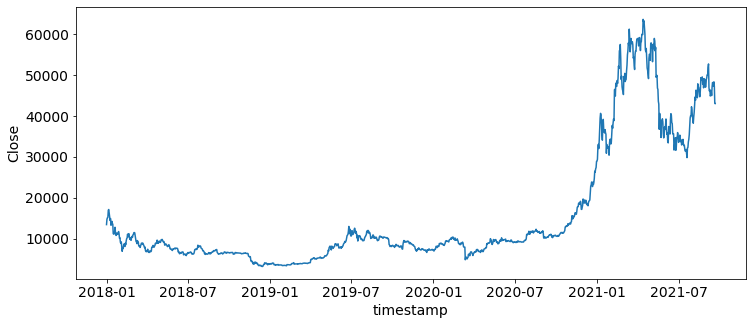

ADF Statistic: -0.422392
p-value: 0.906293
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Non-stationary


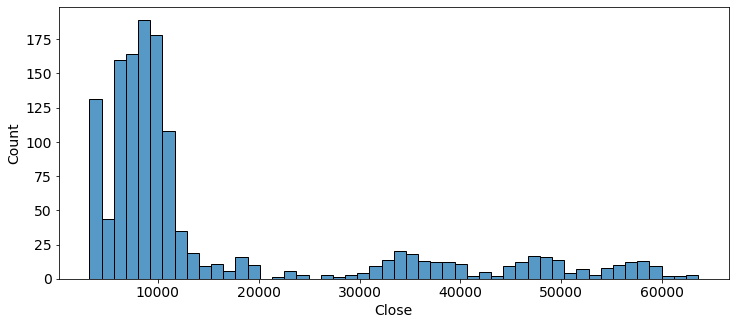

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))

sns.lineplot(data=train_mini, x='timestamp', y='Close')
plt.show()

check_stationarity(train_mini['Close'])

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))

sns.histplot(train_mini['Close'] )
plt.show()

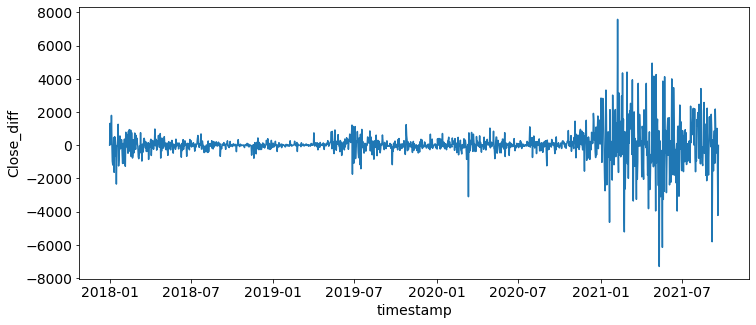

ADF Statistic: -7.377094
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Stationary


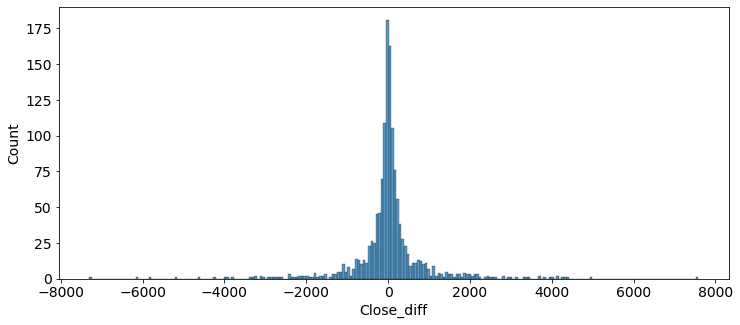

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))

train_mini['Close_diff'] = train_mini['Close'].diff().fillna(0)
sns.lineplot(data=train_mini, x='timestamp', y='Close_diff')
plt.show()

check_stationarity(train_mini['Close_diff'])

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))

sns.histplot(train_mini['Close_diff'] )
plt.show()

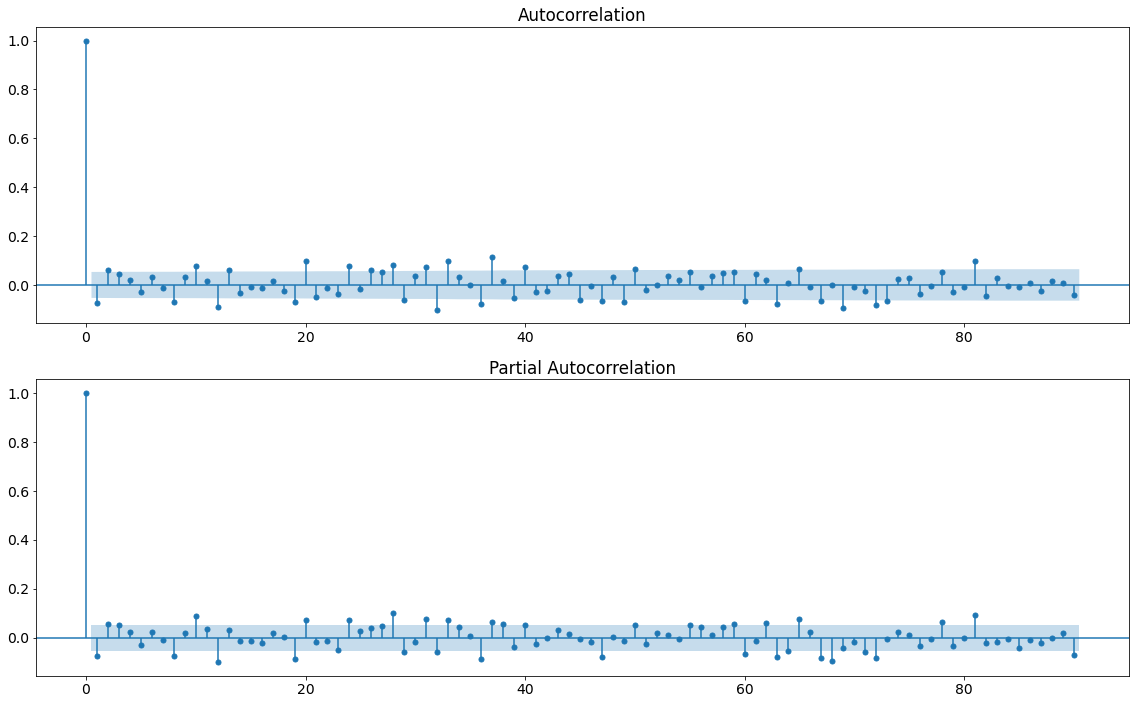

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,10))

plot_acf(train_mini['Close_diff'], lags=90, ax=ax[0])
plot_pacf(train_mini['Close_diff'], lags=90, ax=ax[1])

plt.tight_layout()
plt.show()

# My Other Time Series Forecasting Notebooks

- [Intro to Time Series Forecasting](https://www.kaggle.com/iamleonie/intro-to-time-series-forecasting)
- [Time Series Forecasting: Building Intuition](https://www.kaggle.com/iamleonie/time-series-forecasting-building-intuition)

# Other Ressources
- https://www.linkedin.com/pulse/reading-acf-pacf-plots-missing-manual-cheatsheet-saqib-ali/
- https://www.itl.nist.gov/div898/handbook/eda/section3/autocopl.htm
- https://mxplus3.medium.com/interpreting-autocorrelation-partial-autocorrelation-plots-for-time-series-analysis-23f87b102c64
